 # Exercise 10: Transient universe with MCMCs

 1) Read in `solutions/transient.npy`. This is a (10 x 3) numpy array, containing some time-series measurements from a transient phenomenon. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.

2) One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.

Code this burst model, and code a likelihood function for this data with the burst model. *Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now $x$ is time, and the polynomial model is now the burst model.* 

3) Using one of the MCMC sampler that we looked at in class (`emcee`, `pymc3`), perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$.

4) Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).

5) Make a corner plot of the $4$-D parameter space, with labels, $[68,95]\%$ credible levels and quantiles, and titles.

6) Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these $100$ burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.

7) For each parameter, find the median and 90% credible region of the marginalized distribution and quote results as, for instance, $t_0=X^{+Y}_{-Z}$ 

---

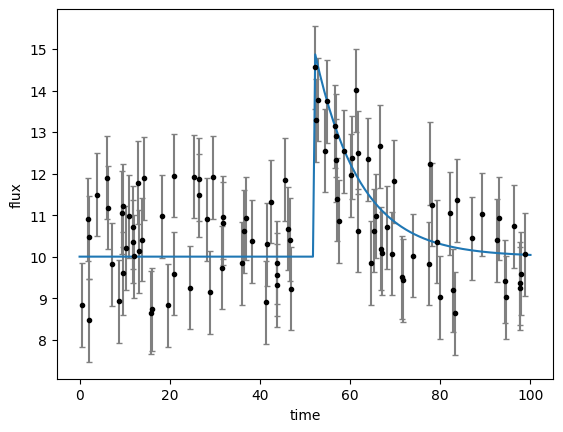

In [1]:
import numpy as np
import pylab as plt

data= np.load('transient.npy')
t, flux, err = data.T

def burst_model(theta, t):
    b, A, t0, alpha = theta
    return np.where(t < t0, b, b + A * np.exp( - alpha * (t - t0)))

theta_guess = np.array([10, 5, 52, 0.1]) # Parameters guessed graphically from plot

xgrid = np.linspace(0,100,200)

plt.errorbar(t, flux ,yerr=err, fmt ='.k', ecolor = 'gray', capsize = 2)
plt.xlabel("time")
plt.ylabel("flux")
plt.plot(xgrid, burst_model(theta_guess,xgrid))



Guessed parameters are quite good

In [2]:
b_min, b_max = 0, 50
A_min, A_max = 0, 50
t0_min, t0_max = 0, 100
alpha_min, alpha_max = np.exp(-5), np.exp(5)

def log_likelihood(theta, x, y, sigma, model = burst_model):
    y_model = model(theta, x)
    return - 0.5 * np.sum((y - y_model)**2 / sigma**2)

def log_prior(theta):
    b, A, t0, alpha = theta
    if b_min < b < b_max and A_min < A < A_max and t0_min < t0 < t0_max and alpha_min < alpha < alpha_max:
        return - np.log(alpha) 
    return - np.inf #log(0)

def log_posterior(theta, t, flux, err, model = burst_model):
    return log_likelihood(theta, t, flux, err, model) + log_prior(theta)

In [3]:
import emcee

# emcee params
ndim = 4 
nwalkers = 25
nsteps = int(1e4)

# initial parameter guess
theta_guess = np.array([10, 5, 52, 0.1]) + np.random.rand(nwalkers, ndim) * 0.1

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[t, flux, err, burst_model])
sampler.run_mcmc(theta_guess, nsteps);

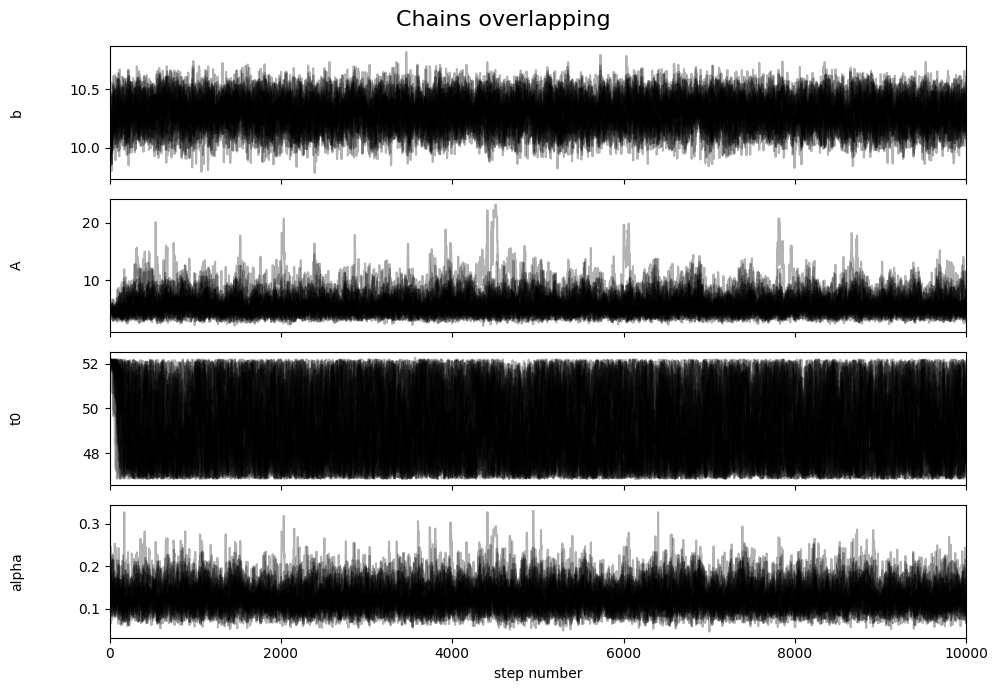

In [5]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["b","A","t0","alpha"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")
fig.suptitle('Chains overlapping', fontsize=16)
fig.tight_layout()

In [45]:
corr_time = sampler.get_autocorr_time()
final_samples = np.asarray(sampler.get_chain(thin = int(max(corr_time)), discard = 4 * int(max(corr_time)), flat = True))
final_samples.shape

(2925, 4)

We obtained around 3000 points from 10000 after thinning

Text(0.5, 0.98, '4-D corner plot')

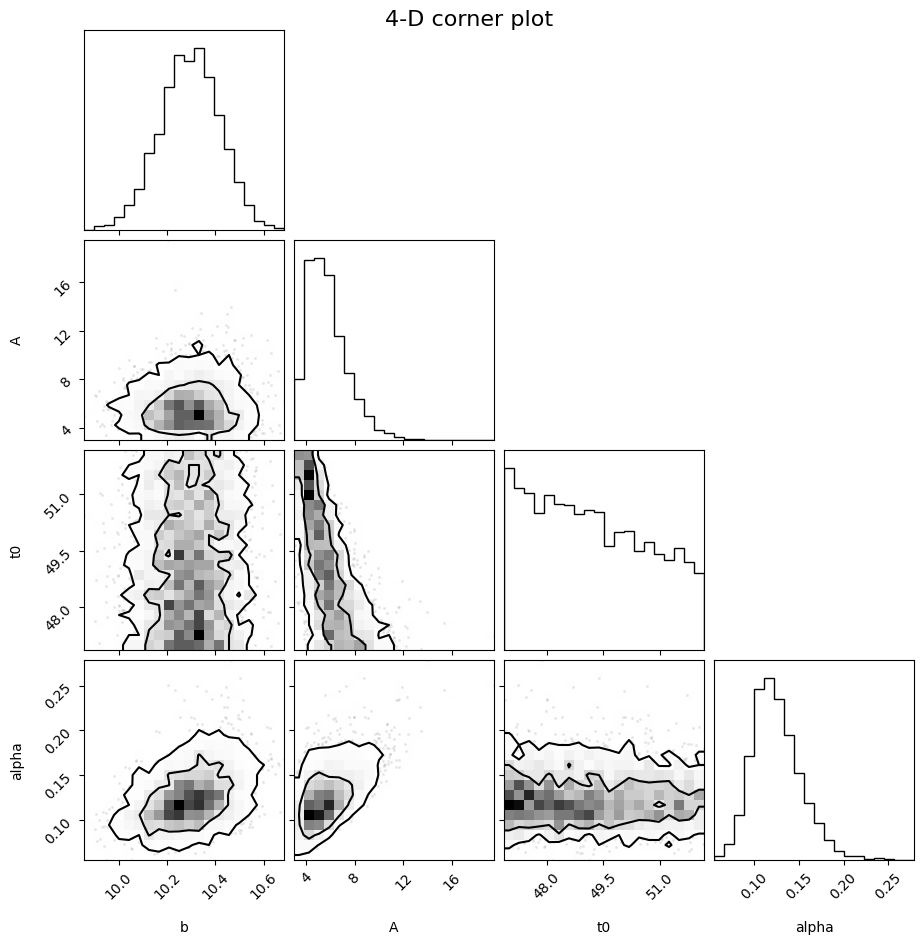

In [46]:
import corner

fig = corner.corner(final_samples, labels=labels, levels=[0.68,0.95]);
fig.suptitle('4-D corner plot', fontsize=16)


Text(0.5, 1.0, 'Model spread given parameter posteriors')

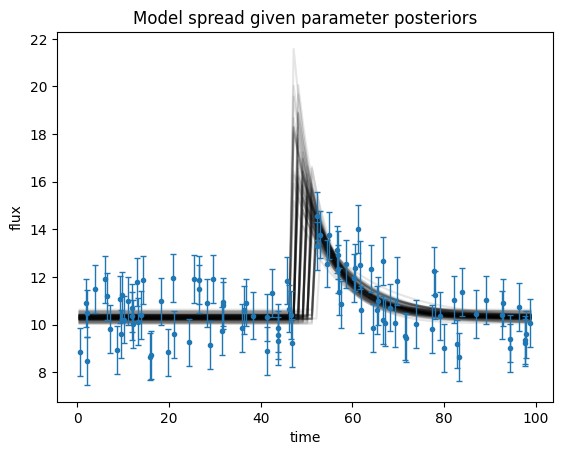

In [54]:
# 100 random samples
N_rand = 100
mask = np.random.choice(len(final_samples), size = N_rand)
choices = final_samples[mask]
grid = np.linspace(min(t), max(t), 100)

#plot
for choice in choices:
    plt.plot(grid, burst_model(choice, grid), c='k', alpha = .1)
    
plt.errorbar(t, flux, yerr = err, fmt ='.', capsize = 2, lw=1)

plt.xlabel("time")
plt.ylabel("flux")
plt.title('Model spread given parameter posteriors')

In [80]:
for i, label in enumerate(labels):
    low, med, sup = np.percentile(final_samples[:,i],[5,50,95]) 
    print(f'{label}\t=\t{med:.2f}\t+{sup-med:.2f}\t-{med-low:.2f}')


b	=	10.30	+0.20	-0.21
A	=	5.47	+3.42	-1.77
t0	=	49.04	+2.71	-2.00
alpha	=	0.12	+0.05	-0.04
